## Standard Star Gamma Ursa Majoris, 30sek

In [ ]:
import os
import sys
import shutil
import platform
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
import matplotlib.patches as mpatch
import numpy as np
import math
from scipy.interpolate import interp1d
#import ipywidgets as wdg  # Using the ipython notebook widgets
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import ccdproc
import scipy.signal

# usually not contained within anacondy, thus added manually

sys.path.append('/Users/Micha/Workspaces/python/spectroscopy')
from whsdadoslib.data import DataProcessing, DataFile
from whsdadoslib.report import Report
from whsdadoslib.show import Show
from whsdadoslib.calibration import CalibrationData
from whsdadoslib.targets import Targets
from whsdadoslib.processing import ProcessingData

In [2]:
# Settings for GAMMA UMA, 30sec

plot_title = 'GAM UMA'
prefix = 'GAMUMA_Light_30,000'
filename_pattern = prefix + 'secs_00000%03d.fits.gz'
filename_index = 250
exposure_time = 30.0
date_yyyymmdd = '20200207'
masterdark_file = 'masterdark_030sec.npy'
correct_dark = True
figure_width = 15
figure_height = 12
peaks = [1410, 1730, 1832, 2143, 2243, 2567, 3500]
lines = [6563,4861,4340,4102]
descs = ['H-alpha','H-beta','H-gamma','H-delta']

In [3]:
# derived via https://www.google.de/maps/place/51°23'37.4%22N+6°58'43.0%22E/@51.3927894,6.9783578,138a,35y,39.46t/data=!3m1!1e3!4m13!1m6!3m5!1s0x47b8c35e2c65526f:0xe6c329dadcd6346a!2sSternwarte+Walter+Hohmann!8m2!3d51.3943807!4d6.978807!3m5!1s0x0:0x0!7e2!8m2!3d51.393716!4d6.9786111

observatory = {
    'name':'WHS',
    'earth_location': EarthLocation(
        lat=51.393716*u.deg, 
        lon=6.978611*u.deg, 
        height=120*u.m),
    'utc_offset':1*u.hour
}

In [4]:
from locallib.observatory import Observatory
whs = Observatory("whs.json")
print (whs.dict())

{'name': 'WHS', 'earth_location': <EarthLocation (3958426.20113413, 484533.69952253, 4961086.52908155) m>, 'utc_offset': <Quantity 1. h>}


In [5]:

if 'Venus' in platform.node():
    src_path = os.path.join('/Users','Micha','data',date_yyyymmdd,'src')
    fits_path  = os.path.join('/Users','Micha','data',date_yyyymmdd,'data')
    corr_path = os.path.join('/Users','Micha','data',date_yyyymmdd,'corr')
    products_path = os.path.join('/Users','Micha','data',date_yyyymmdd,'products')
else:
    src_path = os.path.join('d:/','Workspaces','data',date_yyyymmdd,'src')
    fits_path = os.path.join('d:/','Workspaces','data',date_yyyymmdd,'data')
    corr_path = os.path.join('d:/','Workspaces','data',date_yyyymmdd,'corr')
    products_path = os.path.join('d:/','Workspaces','data',date_yyyymmdd,'products')


ProcessingData.set_fits_path(fits_path)
ProcessingData.set_corr_path(corr_path)
ProcessingData.set_products_path(products_path)

In [6]:
targets = Targets()
os.chdir(src_path)
targets.update()



{'ALPAQL': {'fullname': 'alpha_aquilae',
  'ra.hms': '297d41m44.9783s',
  'dec.dms': '8d52m05.9563s',
  'frame': 'icrs',
  'radec': <SkyCoord (ICRS): (ra, dec) in deg
      (297.69582731, 8.86832119)>},
 'GAMCAS': {'fullname': 'gamma_cassiopeiae',
  'ra.hms': '14d10m37.9755s',
  'dec.dms': '60d43m00.265s',
  'frame': 'icrs',
  'radec': <SkyCoord (ICRS): (ra, dec) in deg
      (14.17721542, 60.71674028)>},
 'DELCEP': {'fullname': 'delta_cephei',
  'ra.hms': '337d17m33.9753s',
  'dec.dms': '58d24m54.7139s',
  'frame': 'icrs',
  'radec': <SkyCoord (ICRS): (ra, dec) in deg
      (337.29277092, 58.41519831)>},
 'ALPCMI': {'fullname': 'alpha_canis_majoris',
  'ra.hms': '101d17m13.7592s',
  'dec.dms': '-16d42m58.0171s',
  'frame': 'icrs',
  'radec': <SkyCoord (ICRS): (ra, dec) in deg
      (101.28715533, -16.71611586)>},
 'PCYG': {'fullname': 'P_cygni',
  'ra.hms': '304d26m48.0313s',
  'dec.dms': '38d01m58.5527s',
  'frame': 'icrs',
  'radec': <SkyCoord (ICRS): (ra, dec) in deg
      (304.446

full image


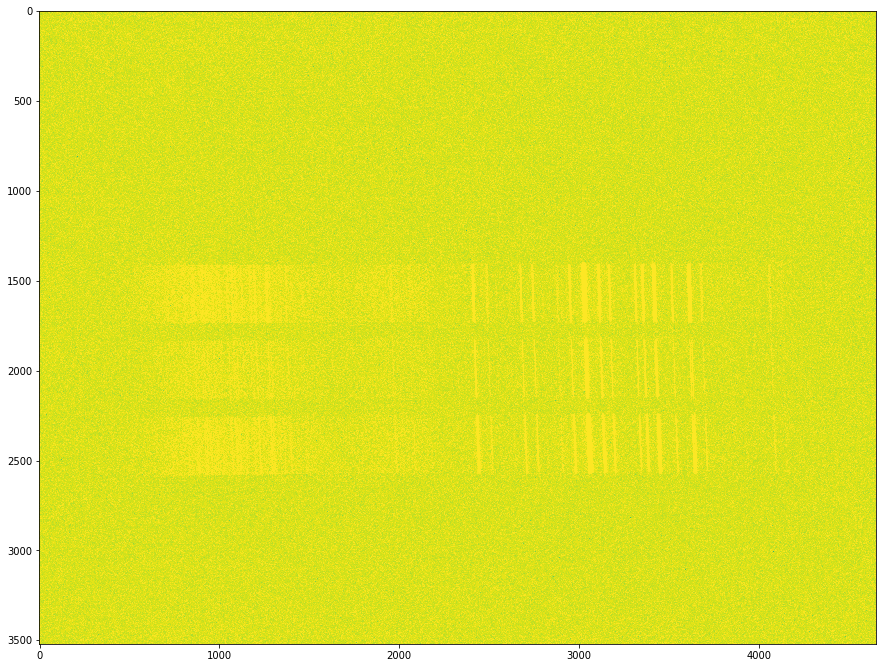

trace along columns


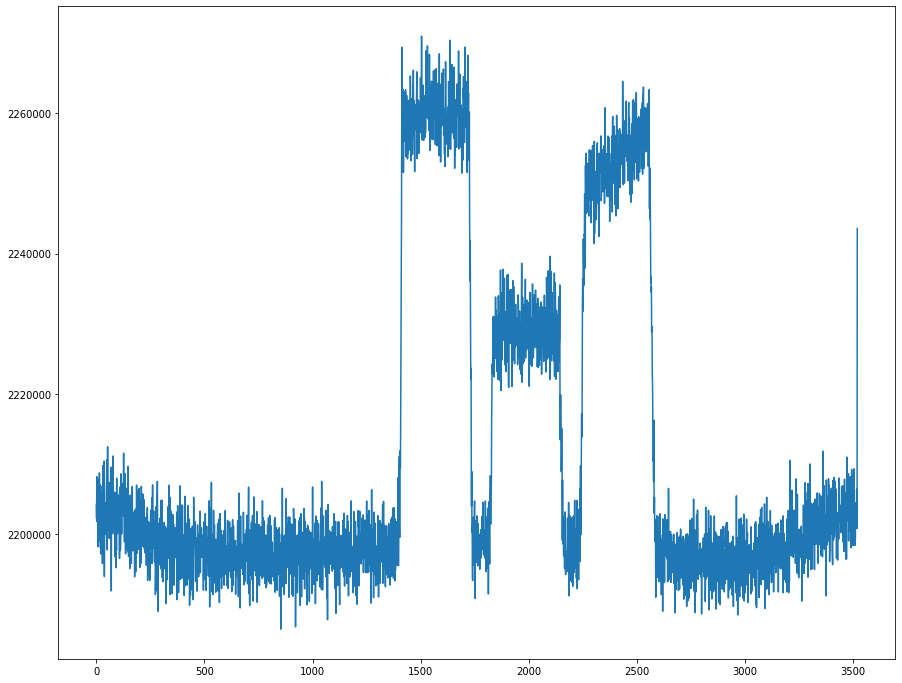

smoothed trace


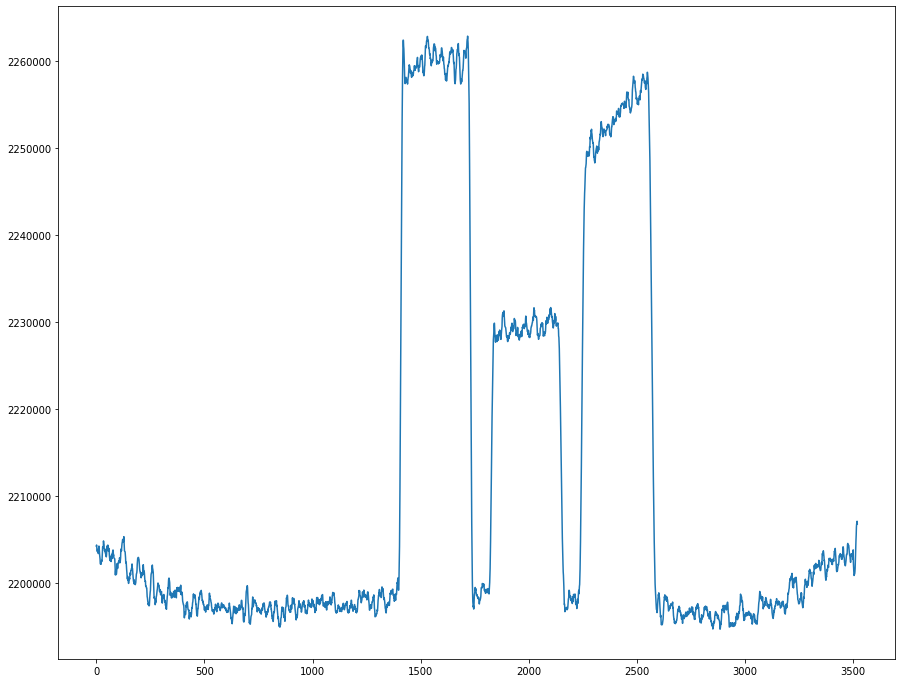

maximum positions of abs(1st derivative)


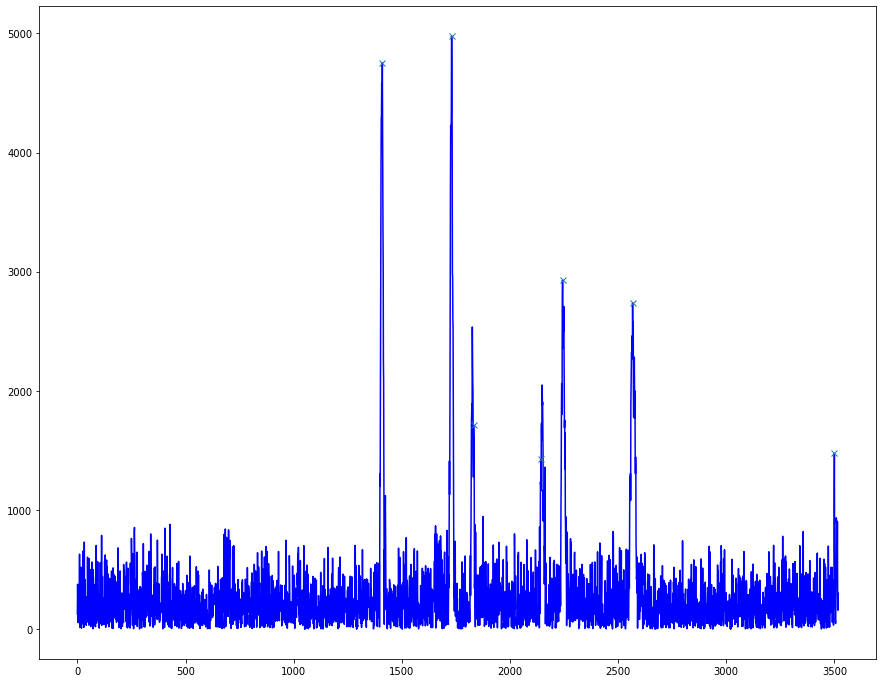

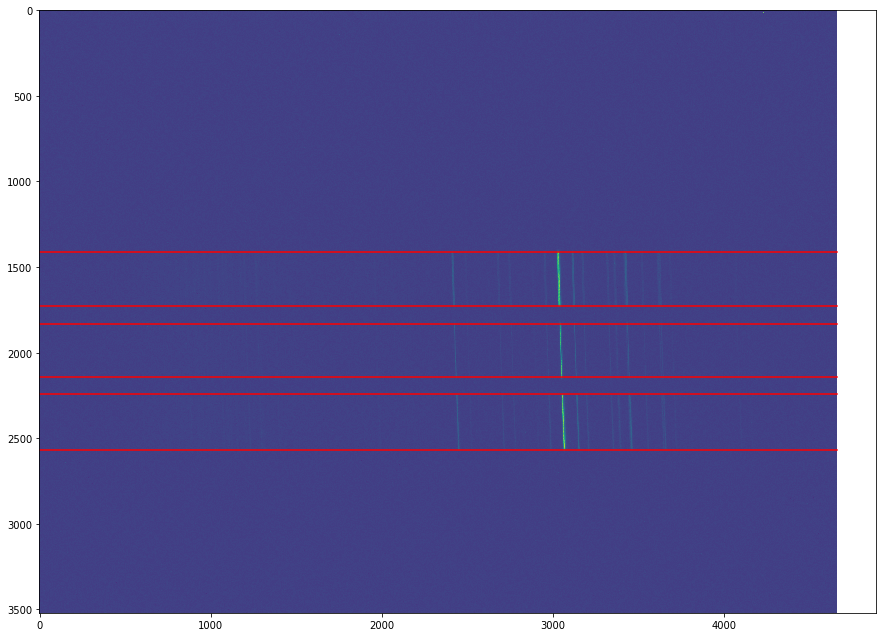

slit rows [1410 1730 1832 2143 2243 2567 3500]
[1410 1730 1832 2143 2243 2567 3500]


In [7]:
from astropy.io import fits
hdul = fits.open(os.path.join(fits_path,'H_AR_Light_1,000secs_00000187.fit'))
h = hdul[0]
peaks = CalibrationData.determine_slit_rows(h.data)
#peaks = [ 819, 1132, 1233, 1538, 1638, 1952]
print (peaks)

In [8]:
cwd = os.getcwd()
os.chdir(products_path)
masterdark = np.load(masterdark_file)
os.chdir(cwd)


In [9]:
#if os.path.exists(os.path.join(ProcessingData.corr_path)):
#    shutil.rmtree(ProcessingData.corr_path)
#os.makedirs(ProcessingData.corr_path)

In [10]:
icl = ccdproc.ImageFileCollection(
    fits_path,
    glob_include=prefix + '*.fit')

In [11]:
for fnames in icl.summary['file']:
    print (fnames)
factors = [1.0 for fname in  icl.summary['file']]

GAMUMA_Light_30,000secs_00000247.fit
GAMUMA_Light_30,000secs_00000248.fit
GAMUMA_Light_30,000secs_00000249.fit
GAMUMA_Light_30,000secs_00000250.fit
GAMUMA_Light_30,000secs_00000251.fit
GAMUMA_Light_30,000secs_00000252.fit
GAMUMA_Light_30,000secs_00000253.fit
GAMUMA_Light_30,000secs_00000254.fit
GAMUMA_Light_30,000secs_00000255.fit
GAMUMA_Light_30,000secs_00000256.fit


In [12]:
DataFile.update_fits_header(fits_path,icl,targets,whs.dict())

GAMUMA_Light_30,000secs_00000247.fits
GAMUMA_Light_30,000secs_00000248.fits
GAMUMA_Light_30,000secs_00000249.fits
GAMUMA_Light_30,000secs_00000250.fits
GAMUMA_Light_30,000secs_00000251.fits
GAMUMA_Light_30,000secs_00000252.fits
GAMUMA_Light_30,000secs_00000253.fits
GAMUMA_Light_30,000secs_00000254.fits
GAMUMA_Light_30,000secs_00000255.fits
GAMUMA_Light_30,000secs_00000256.fits


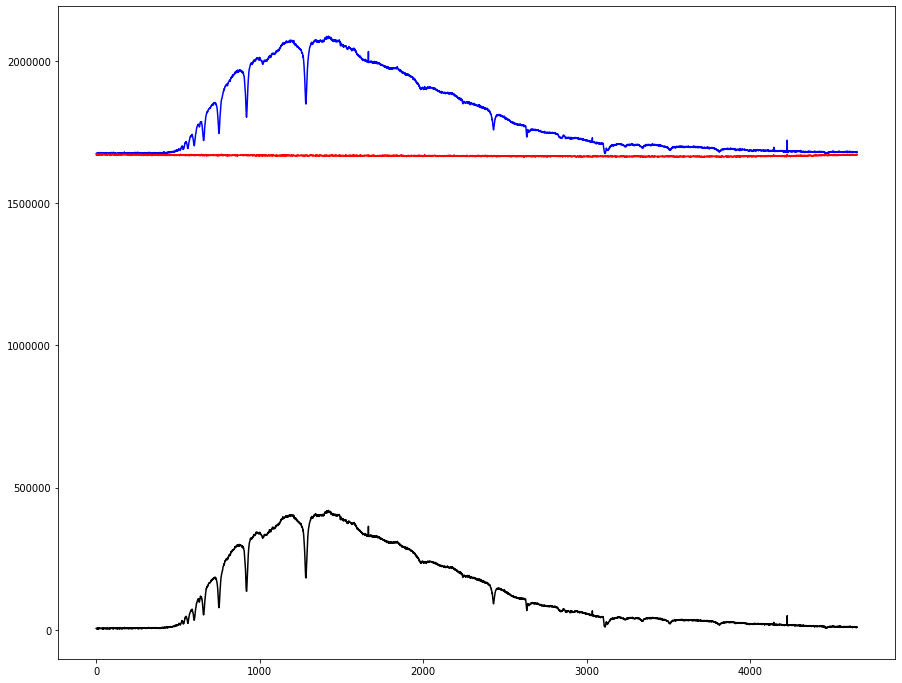

GAMUMA_Light_30,000secs_00000247.fitswritten


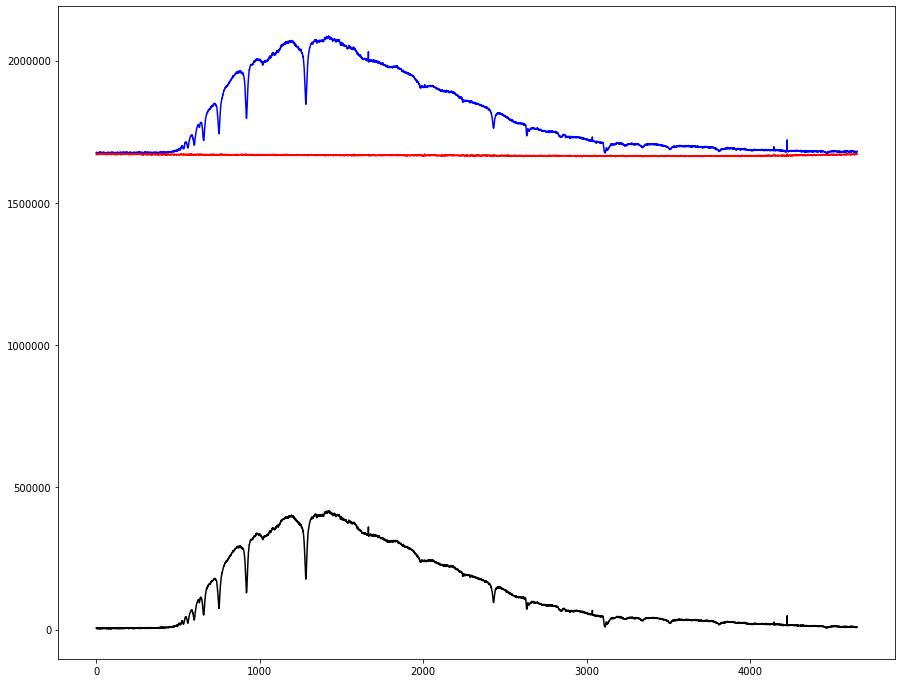

GAMUMA_Light_30,000secs_00000248.fitswritten


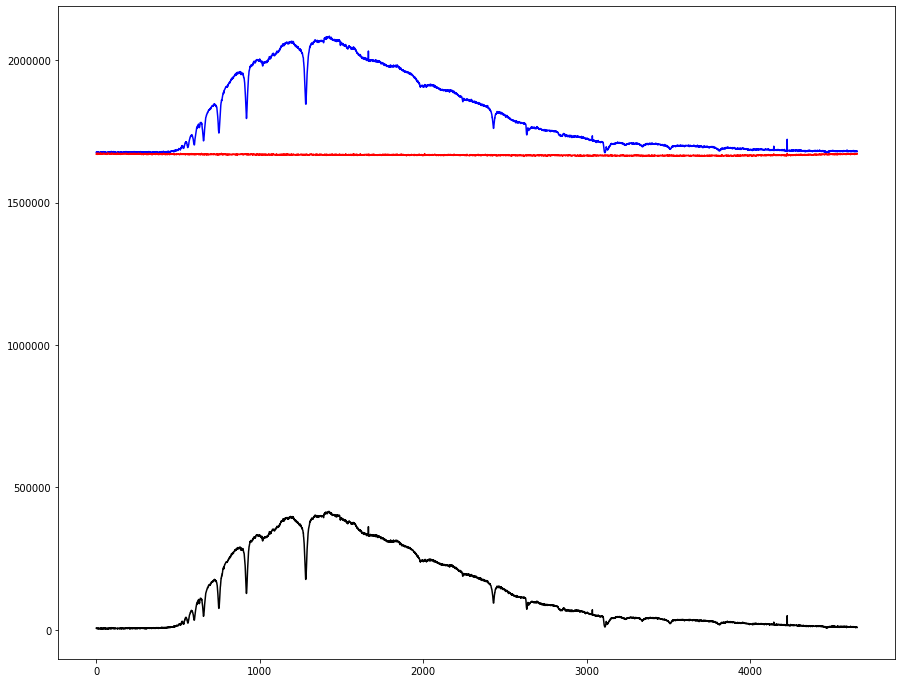

GAMUMA_Light_30,000secs_00000249.fitswritten


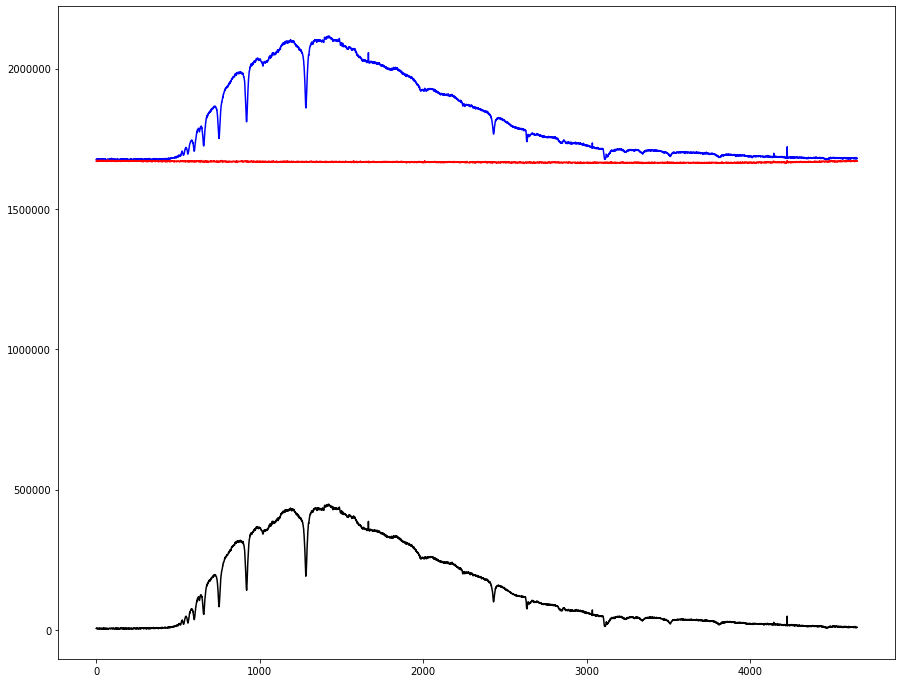

GAMUMA_Light_30,000secs_00000250.fitswritten


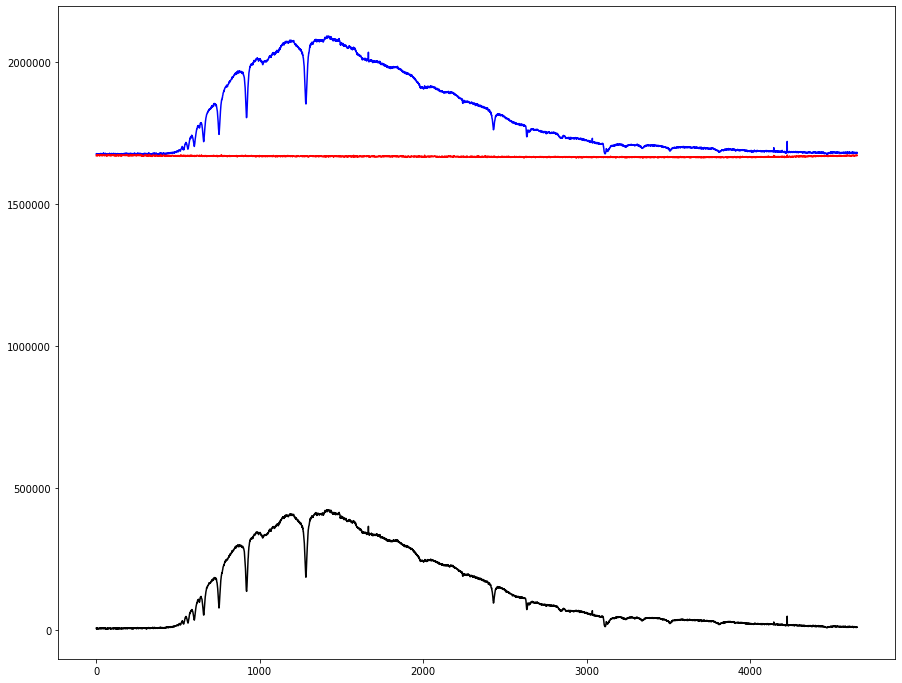

GAMUMA_Light_30,000secs_00000251.fitswritten


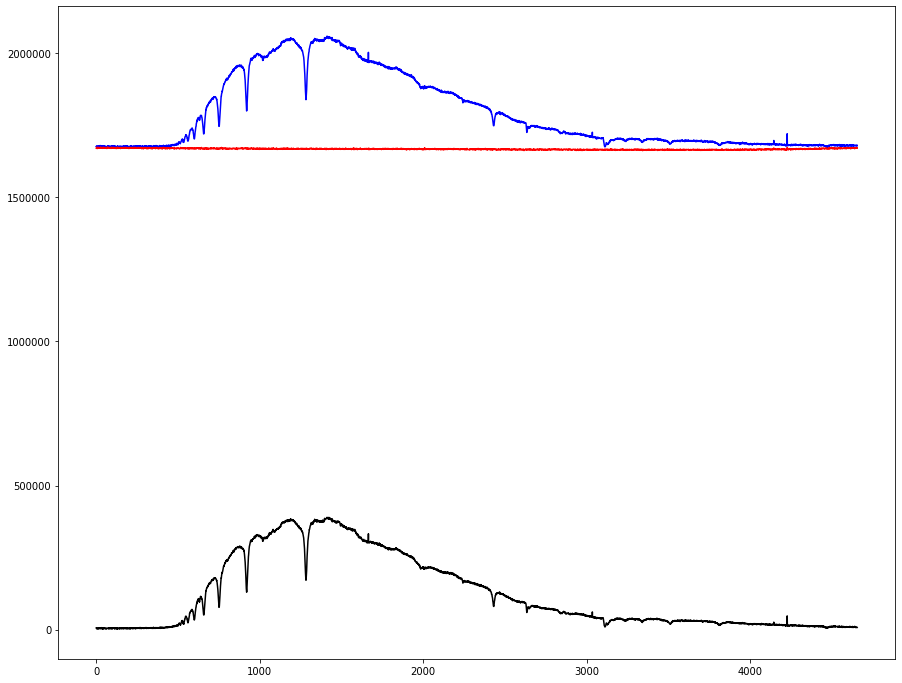

GAMUMA_Light_30,000secs_00000252.fitswritten


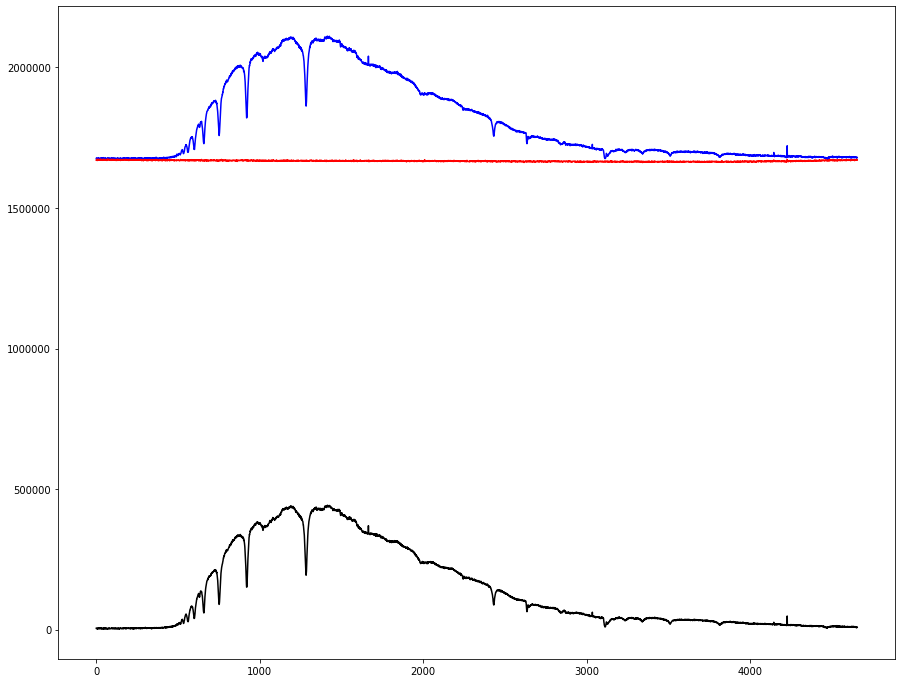

GAMUMA_Light_30,000secs_00000253.fitswritten


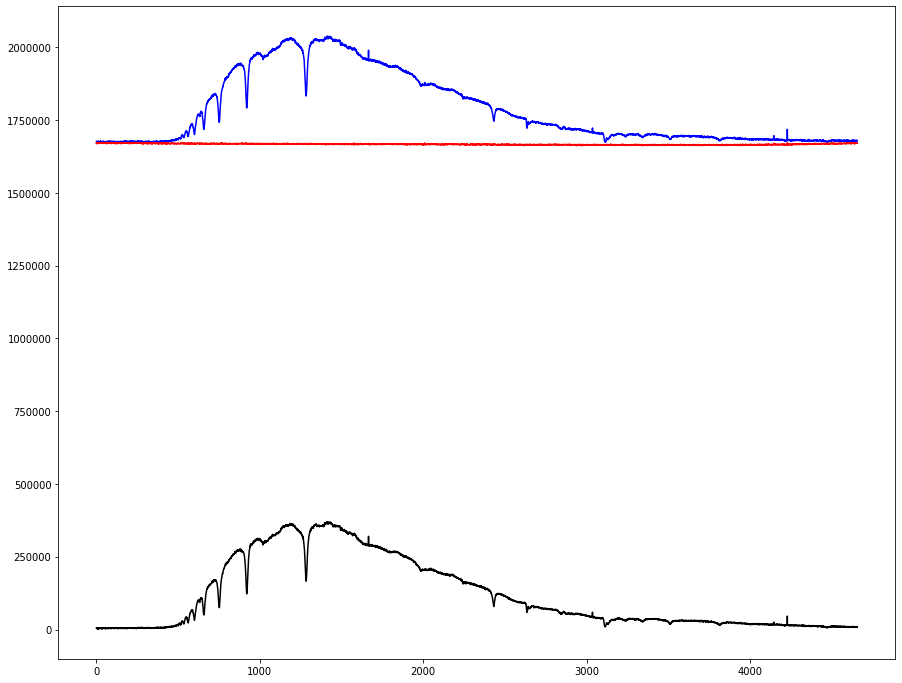

GAMUMA_Light_30,000secs_00000254.fitswritten


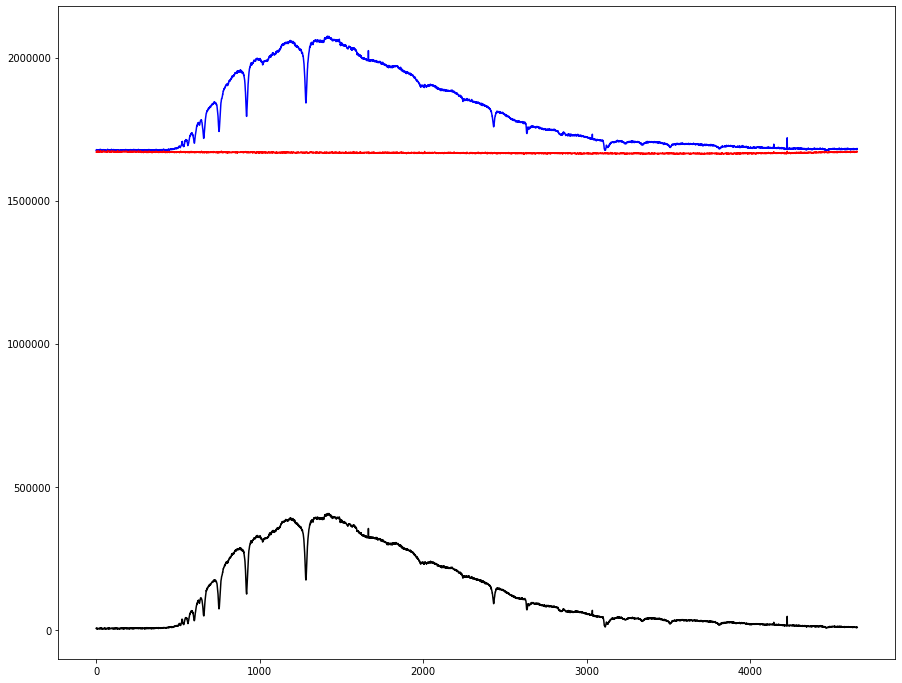

GAMUMA_Light_30,000secs_00000255.fitswritten


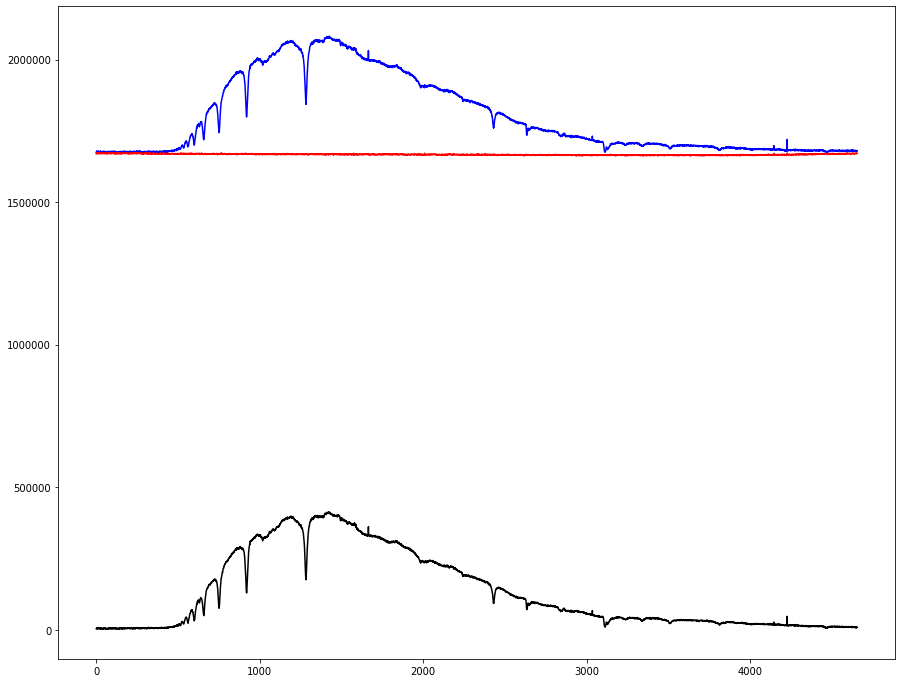

GAMUMA_Light_30,000secs_00000256.fitswritten


In [13]:
if correct_dark == True:
    icl = ccdproc.ImageFileCollection(
    fits_path,
    glob_include=prefix + '*.fits')
    dp = DataProcessing(masterdark=masterdark)
    dp.correct_dark(icl, plot=True, fliplr=False)

In [14]:
icl = ccdproc.ImageFileCollection(
    fits_path,
    glob_include=prefix + '*.fits')

In [15]:
report = Report(observatory=whs.dict())
report.list_measurements(icl, targets)

n   file                                 target     DATE-OBS                 alt        secz     °C   
  0 GAMUMA_Light_30,000secs_00000247.fits GAMUMA     2020-02-07T20:30:44.176   40.6 deg  1.53704  -9.8
  1 GAMUMA_Light_30,000secs_00000248.fits GAMUMA     2020-02-07T20:31:16.885   40.7 deg  1.53496  -9.8
  2 GAMUMA_Light_30,000secs_00000249.fits GAMUMA     2020-02-07T20:31:49.340   40.7 deg  1.53290 -10.0
  3 GAMUMA_Light_30,000secs_00000250.fits GAMUMA     2020-02-07T20:32:21.795   40.8 deg  1.53084 -10.0
  4 GAMUMA_Light_30,000secs_00000251.fits GAMUMA     2020-02-07T20:32:54.250   40.9 deg  1.52880 -10.0
  5 GAMUMA_Light_30,000secs_00000252.fits GAMUMA     2020-02-07T20:33:26.731   40.9 deg  1.52675 -10.1
  6 GAMUMA_Light_30,000secs_00000253.fits GAMUMA     2020-02-07T20:33:59.201   41.0 deg  1.52472 -10.1
  7 GAMUMA_Light_30,000secs_00000254.fits GAMUMA     2020-02-07T20:34:31.649   41.1 deg  1.52269 -10.1
  8 GAMUMA_Light_30,000secs_00000255.fits GAMUMA     2020-02-07T20:35:04.

In [16]:
show = Show()

560464
560352
556160
587920
563520
532576
584000
511280
547280
554896


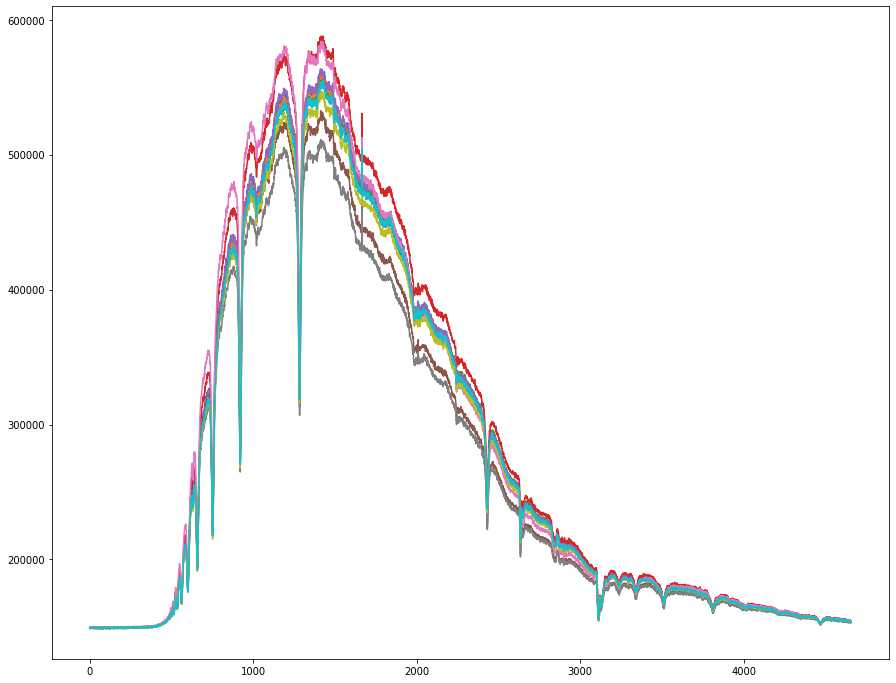

In [17]:
show.plots(icl, ylim=[peaks[2], peaks[3]], factors=factors)

In [18]:
filename = filename_pattern % (filename_index)
star = DataFile(filename, fits_path=corr_path)
star.read()

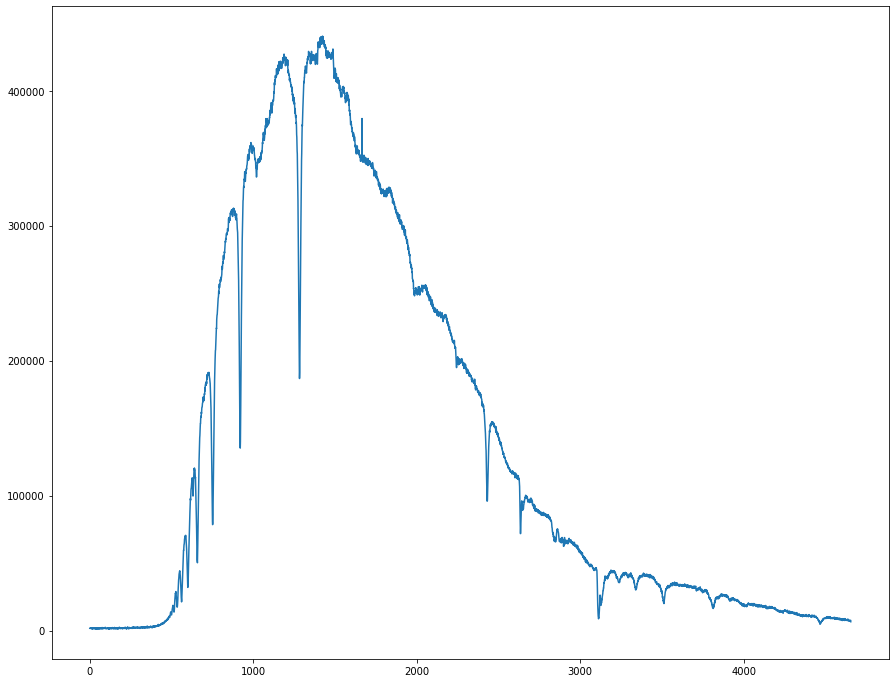

In [19]:
traces = star.data[peaks[2]:peaks[3],:].sum(axis=0)
pixelnumbers = range(0,4656)
plt.plot(pixelnumbers,traces)

In [20]:
with open('pixels.dat','w') as f:
    for pixel in pixelnumbers:
        f.write(str(pixel)+'\n')

with open('traces.dat','w') as f:
    for trace in traces:
        f.write(str(trace)+'\n')
    

[3.098695240449246e-05, 1.3641945623567484, 3064.9314933884443]


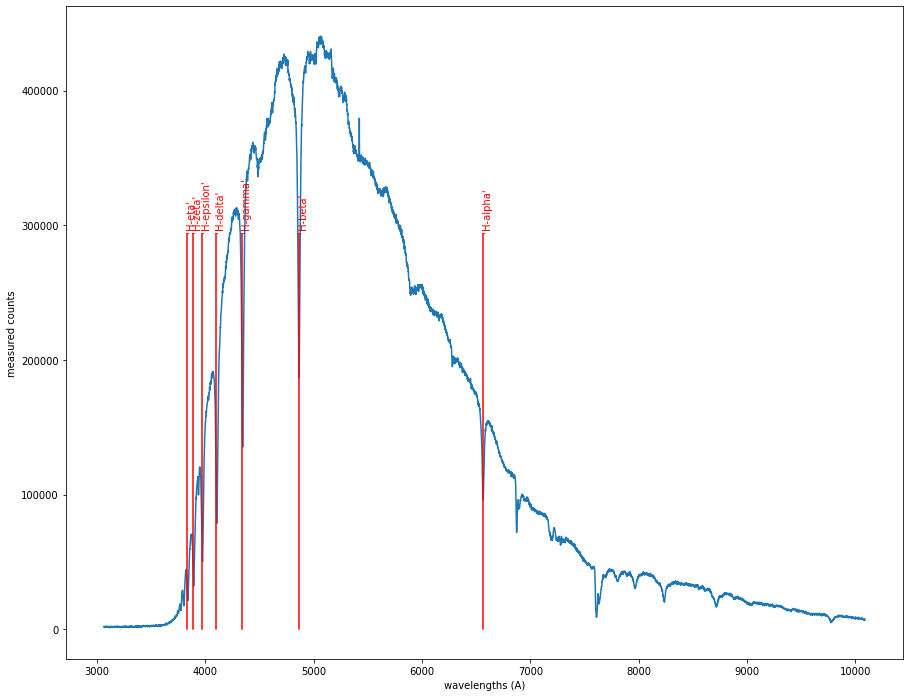

In [21]:
os.chdir(src_path)
wavelengths_file = os.path.join(src_path,'wavelengths.txt')
z = CalibrationData.get_z()
print (z)
CalibrationData.check_wavelengths(traces, wavelengths_file=wavelengths_file)

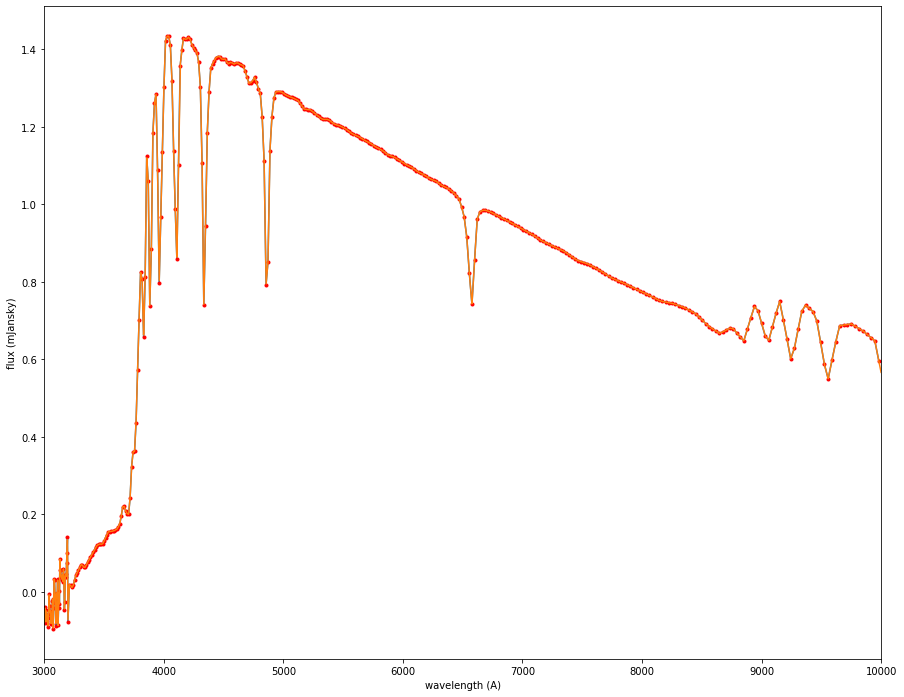

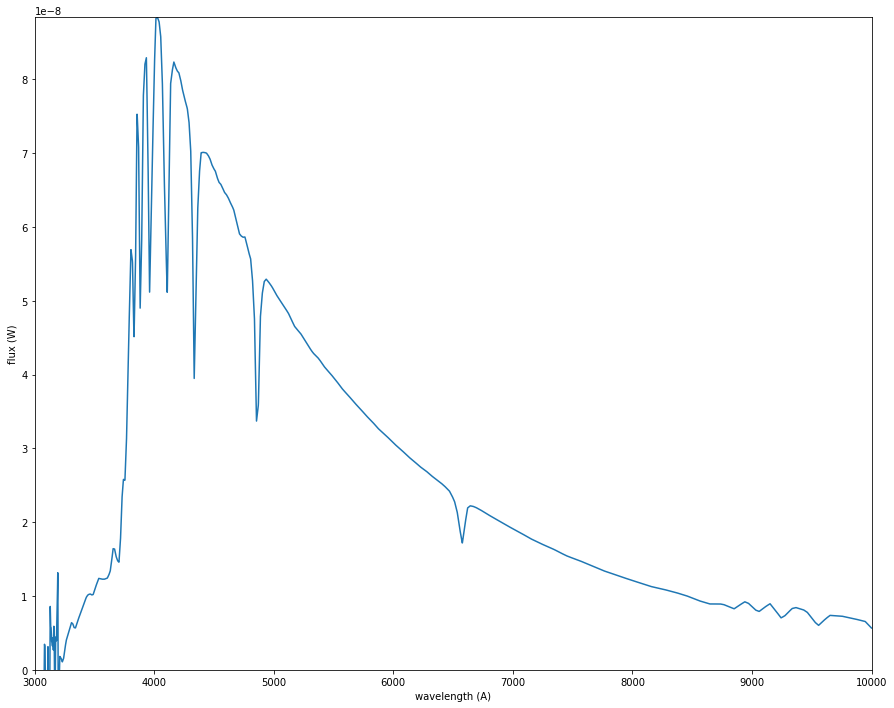

In [22]:
%matplotlib inline

from locallib.calibration import CalibrationData

hst_waves, hst_fluxes = CalibrationData.get_standard_flux('gammaumaa.tab')
hst_fluxes = [flux * (-1)+ 3.8 for flux in hst_fluxes]
Show.show_standard_flux(hst_waves, hst_fluxes)

[3.098695240449246e-05, 1.3641945623567484, 3064.9314933884443]


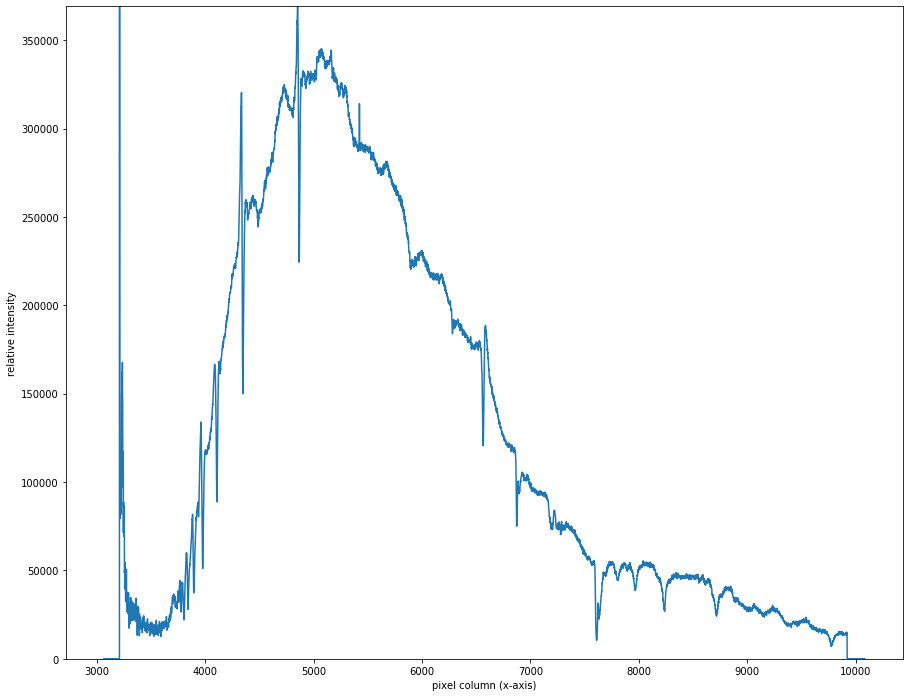

In [23]:
CalibrationData.prepare_instrumentfunction(traces, hst_waves, hst_fluxes, offset=0)


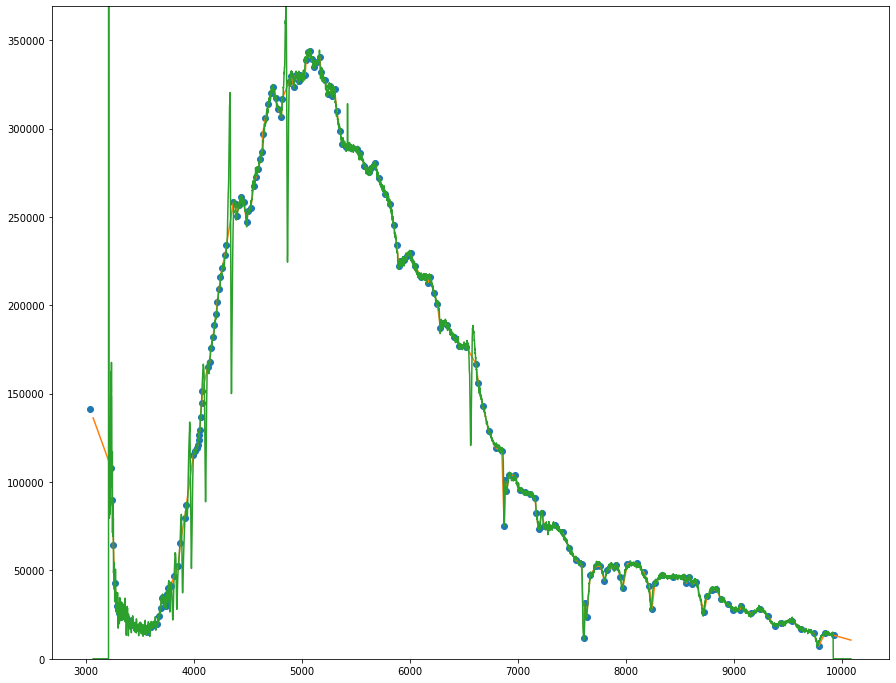

In [26]:
plt.rcParams['figure.figsize'] = [Show.figure_width, Show.figure_height]

os.chdir(src_path)
waves, instr_waves = CalibrationData.get_instrumentfunction(xpos_ypos_dat='xpos_ypos_30s.dat')

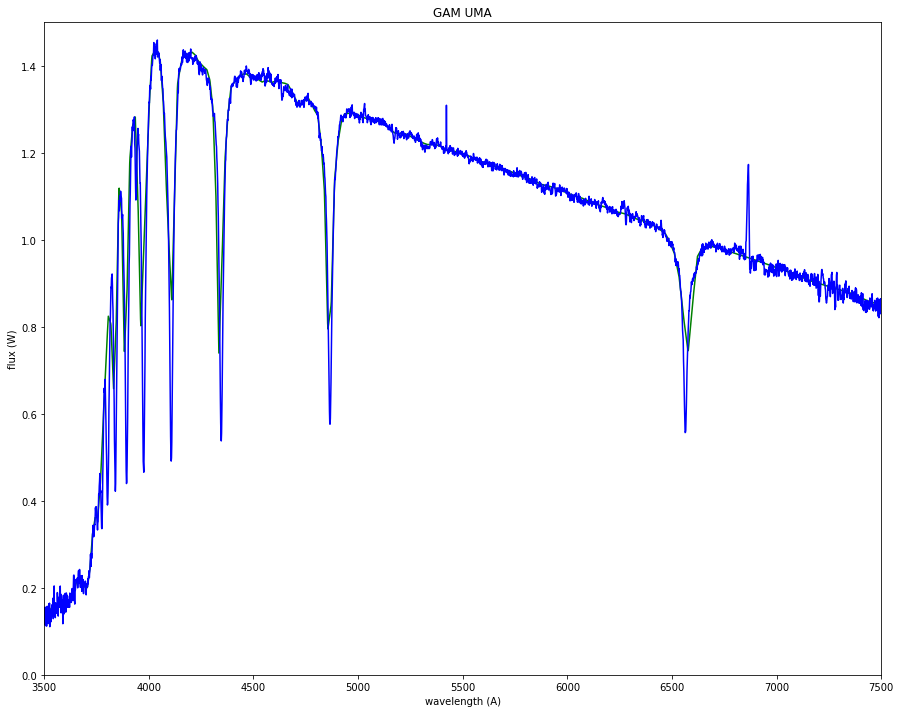

In [31]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [figure_width, figure_height]
fig, ax = plt.subplots()

flux_star = []

for i in range(0,len(waves)):
    if instr_waves[i] == 0.0:
        flux_star.append(0.0)
    else:
        flux_star.append(traces[i]/instr_waves[i])

#plt.plot(waves,flux_star, color='blue')
f_star = interp1d(hst_waves, hst_fluxes, fill_value="extrapolate")
f_star_mjansky = f_star(waves)
#f_watt = f_vega_mjansky
plt.plot(waves,f_star_mjansky,color='g')

#max_i = max(flux_star)
plt.plot(waves,flux_star, color='blue')   
plt.ylim(0,1.5)
plt.xlim(3500,7500)
plt.xlabel('wavelength (A)')
plt.ylabel('flux (W)')
plt.title(plot_title)

#plt.text(5500,4.4e9,'WHS 30cm + DADOS 200 Lines/mm 25 mu + ASI 1600MM Pro', color='blue')
#plt.text(5500,4.2e9,'HST Standard Flux 5A', color='green')
plt.show()